In [23]:
# Installing H2O; uncomment of H2O is not installed
# !pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

# Installing H2O dependencies
# !pip install requests
# !pip install tabulate
# !pip install "colorama>=0.3.8"
# !pip install future

#uncomment of xgboost not installed
# !pip install xgboost

#uncomment if pydotplus not installed; dependency for graphviz
# !pip install pydotplus
# !pip install pydot

# weights and biases for experiment tracking
# !pip install wandb

# category-encoder
# !pip install category_encoders

# uncomment if never before installed and need to convert to onnx
# !pip install onnx
# !pip install skl2onnx
# !pip install onnxruntime
# !pip install onnxmltools



In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, SCORERS
from sklearn import ensemble

from category_encoders import OneHotEncoder, TargetEncoder, WOEEncoder

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from six import StringIO
from IPython.display import Image

import pydotplus
import graphviz

import wandb
import os

import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OTargetEncoderEstimator

In [25]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Loading Data

In [26]:
train = pd.read_csv('../Data/interim/train.csv')
test = pd.read_csv('../Data/interim/test.csv')
validate = pd.read_csv('../Data/interim/validate.csv')
production = pd.read_csv('../Data/interim/production.csv')

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77692 entries, 0 to 77691
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   satisfaction                       77692 non-null  object
 1   Gender                             77692 non-null  object
 2   Customer Type                      77692 non-null  object
 3   Age                                77692 non-null  int64 
 4   Type of Travel                     77692 non-null  object
 5   Class                              77692 non-null  object
 6   Flight Distance                    77692 non-null  int64 
 7   Seat comfort                       77692 non-null  int64 
 8   Departure/Arrival time convenient  77692 non-null  int64 
 9   Food and drink                     77692 non-null  int64 
 10  Gate location                      77692 non-null  int64 
 11  Inflight wifi service              77692 non-null  int64 
 12  Infl

In [28]:
train.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Male,Loyal Customer,37,Business travel,Business,3785,4,4,4,...,4,4,4,4,4,5,4,4,1,9
1,dissatisfied,Male,Loyal Customer,60,Personal Travel,Eco,1784,3,4,3,...,2,5,3,2,4,4,4,5,0,0
2,dissatisfied,Male,Loyal Customer,27,Business travel,Business,1825,2,3,4,...,2,2,1,3,3,1,2,2,76,57
3,satisfied,Male,Loyal Customer,50,Business travel,Eco,2024,4,4,2,...,4,4,2,5,4,2,4,4,125,129
4,dissatisfied,Male,Loyal Customer,70,Personal Travel,Eco,1435,4,4,4,...,5,5,5,4,5,4,4,5,0,0


In [29]:
# data.dropna(axis=1, inplace=True)

In [30]:
data = pd.read_csv('../Data/raw/Invistico_Airline.csv')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0], test_size=0.2, random_state=16)

# Checking for class-imbalance

satisfied       56851
dissatisfied    47053
Name: satisfaction, dtype: int64


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


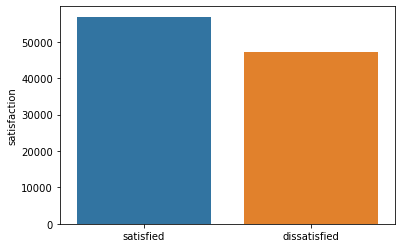

In [32]:
# train data check
x = y_train.value_counts()
print(x)
sns.barplot(x.index, x)

satisfied       14236
dissatisfied    11740
Name: satisfaction, dtype: int64


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


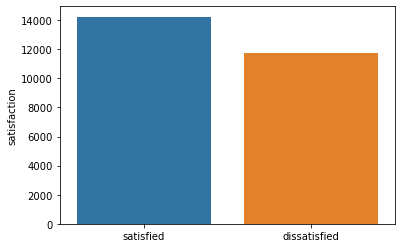

In [33]:
# test data check
x = y_test.value_counts()
print(x)
sns.barplot(x.index, x)

# Identifying Categorical & Numerical features

In [34]:
numerical_features = [x for x in X_train.select_dtypes(exclude = object)]
categorical_features = [x for x in X_train.select_dtypes(include = object)]

In [35]:
print("The numerical features of the dataset are:")
for _ in numerical_features: print(_)

The numerical features of the dataset are:
Age
Flight Distance
Seat comfort
Departure/Arrival time convenient
Food and drink
Gate location
Inflight wifi service
Inflight entertainment
Online support
Ease of Online booking
On-board service
Leg room service
Baggage handling
Checkin service
Cleanliness
Online boarding
Departure Delay in Minutes
Arrival Delay in Minutes


In [57]:
print("The categorical features of the dataset are:")
for _ in categorical_features: print(_)

The categorical features of the dataset are:
Gender
Customer Type
Type of Travel
Class


In [37]:
for f in categorical_features:
    print("\nThe unique labels in {} is {}".format(f, X_train[f].unique()))
    print("The values in {} is \n{}\n".format(f,  X_train[f].value_counts()))


The unique labels in Gender is ['Male' 'Female']
The values in Gender is 
Female    52738
Male      51166
Name: Gender, dtype: int64


The unique labels in Customer Type is ['Loyal Customer' 'disloyal Customer']
The values in Customer Type is 
Loyal Customer       84880
disloyal Customer    19024
Name: Customer Type, dtype: int64


The unique labels in Type of Travel is ['Personal Travel' 'Business travel']
The values in Type of Travel is 
Business travel    71797
Personal Travel    32107
Name: Type of Travel, dtype: int64


The unique labels in Class is ['Eco' 'Business' 'Eco Plus']
The values in Class is 
Business    49812
Eco         46581
Eco Plus     7511
Name: Class, dtype: int64



# Encode categorical variables

In [39]:
# ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# train_autoML = pd.DataFrame(ohe_encoder.fit_transform(X_train[categorical_features]), columns=ohe_encoder.get_feature_names_out, index=X_train.index)

In [40]:
# numeric_transformer = StandardScaler()

In [41]:
# preprocessor = ColumnTransformer(
#     transformers=[        
#         ('num', numeric_transformer, numerical_features),
#         ('cat', ohe_encoder, categorical_features)
#         ])


In [42]:
# prep_auto = Pipeline(steps=[('preprocessing', preprocessor)])
# prep_auto.fit(X_train.copy())


In [43]:
# train_auto = prep_auto.transform(X_train.copy())
# test_auto = prep_auto.transform(X_test.copy())

In [44]:
# train_auto.head()

# AutoML

In [5]:
## prepare data
h2o.init()

h2o_train = h2o.H2OFrame(X_train)
h2o_test = h2o.H2OFrame(X_test)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.311-b11, mixed mode)
  Starting server from C:\Users\ADMIN\.conda\envs\mlopslab\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ADMIN\AppData\Local\Temp\tmpw3rf41wu
  JVM stdout: C:\Users\ADMIN\AppData\Local\Temp\tmpw3rf41wu\h2o_ADMIN_started_from_python.out
  JVM stderr: C:\Users\ADMIN\AppData\Local\Temp\tmpw3rf41wu\h2o_ADMIN_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 19 days
H2O_cluster_name:,H2O_from_python_ADMIN_wmgkse
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.507 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [112]:
aml = H2OAutoML(max_models=20,
                seed=16,
                stopping_metric='logloss',
                sort_metric='logloss',
                max_runtime_secs_per_model=300,
                preprocessing=["target_encoding"],
                exclude_algos = ["GLM", "DeepLearning"])

aml.train(y='satisfaction', 
          training_frame=h2o_train)

AutoML progress: |
21:02:52.309: AutoML: XGBoost is not available; skipping it.
21:02:52.310: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
21:02:52.310: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_5_AutoML_2_20211126_210252

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.009333331106775212
RMSE: 0.09660916678439584
LogLoss: 0.04014538133094185
Null degrees of freedom: 9926
Residual degrees of freedom: 9917
Null deviance: 13661.091866799405
Residual deviance: 797.0464009445195
AIC: 817.0464009445195
AUC: 0.9997181355140968
AUCPR: 0.9997717016962354
Gini: 0.9994362710281937

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4548152677163746: 


,,dissatisfied,satisfied,Error,Rate
0,dissatisfied,4429.0,34.0,0.0076,(34.0/4463.0)
1,satisfied,33.0,5431.0,0.006,(33.0/5464.0)
2,Total,4462.0,5465.0,0.0067,(67.0/9927.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.454815,0.993870,199.0
1,max f2,0.384584,0.994923,217.0
2,max f0point5,0.531015,0.995282,181.0
3,max accuracy,0.454815,0.993251,199.0
4,max precision,0.999803,1.000000,0.0
5,max recall,0.134861,1.000000,296.0
6,max specificity,0.999803,1.000000,0.0
7,max absolute_mcc,0.454815,0.986363,199.0
8,max min_per_class_accuracy,0.479070,0.992679,194.0
9,max mean_per_class_accuracy,0.454815,0.993171,199.0



Gains/Lift Table: Avg response rate: 55.04 %, avg score: 55.07 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010074,0.999888,1.816801,1.816801,1.000000,0.999902,1.000000,0.999902,0.018302,0.018302,81.680088,81.680088,0.018302
1,2,0.020046,0.999869,1.816801,1.816801,1.000000,0.999878,1.000000,0.999890,0.018119,0.036420,81.680088,81.680088,0.036420
2,3,0.030019,0.999853,1.816801,1.816801,1.000000,0.999861,1.000000,0.999881,0.018119,0.054539,81.680088,81.680088,0.054539
3,4,0.040093,0.999838,1.816801,1.816801,1.000000,0.999846,1.000000,0.999872,0.018302,0.072840,81.680088,81.680088,0.072840
4,5,0.050065,0.999823,1.816801,1.816801,1.000000,0.999829,1.000000,0.999863,0.018119,0.090959,81.680088,81.680088,0.090959
5,6,0.100030,0.999747,1.816801,1.816801,1.000000,0.999786,1.000000,0.999825,0.090776,0.181735,81.680088,81.680088,0.181735
6,7,0.149995,0.999659,1.816801,1.816801,1.000000,0.999705,1.000000,0.999785,0.090776,0.272511,81.680088,81.680088,0.272511
7,8,0.200060,0.999530,1.816801,1.816801,1.000000,0.999601,1.000000,0.999739,0.090959,0.363470,81.680088,81.680088,0.363470
8,9,0.299990,0.999044,1.816801,1.816801,1.000000,0.999335,1.000000,0.999604,0.181552,0.545022,81.680088,81.680088,0.545022
9,10,0.400020,0.996567,1.816801,1.816801,1.000000,0.998245,1.000000,0.999264,0.181735,0.726757,81.680088,81.680088,0.726757




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.028608993247420892
RMSE: 0.1691419322563772
LogLoss: 0.092661788577921
Null degrees of freedom: 77927
Residual degrees of freedom: 77920
Null deviance: 107342.68510720006
Residual deviance: 14441.895720600454
AIC: 14457.895720600454
AUC: 0.9945226555808395
AUCPR: 0.9957930198605208
Gini: 0.989045311161679

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5448284728639723: 


,,dissatisfied,satisfied,Error,Rate
0,dissatisfied,34191.0,1107.0,0.0314,(1107.0/35298.0)
1,satisfied,2007.0,40623.0,0.0471,(2007.0/42630.0)
2,Total,36198.0,41730.0,0.04,(3114.0/77928.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.544828,0.963087,173.0
1,max f2,0.137781,0.971221,311.0
2,max f0point5,0.808602,0.977156,96.0
3,max accuracy,0.544828,0.960040,173.0
4,max precision,0.999828,1.000000,0.0
5,max recall,0.001120,1.000000,396.0
6,max specificity,0.999828,1.000000,0.0
7,max absolute_mcc,0.544828,0.919791,173.0
8,max min_per_class_accuracy,0.471318,0.959374,196.0
9,max mean_per_class_accuracy,0.610775,0.960990,154.0



Gains/Lift Table: Avg response rate: 54.70 %, avg score: 54.70 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010022,0.999914,1.828008,1.828008,1.000000,0.999930,1.000000,0.999930,0.018320,0.018320,82.800844,82.800844,0.018320
1,2,0.020018,0.999895,1.828008,1.828008,1.000000,0.999904,1.000000,0.999917,0.018274,0.036594,82.800844,82.800844,0.036594
2,3,0.030015,0.999880,1.828008,1.828008,1.000000,0.999887,1.000000,0.999907,0.018274,0.054867,82.800844,82.800844,0.054867
3,4,0.040011,0.999865,1.828008,1.828008,1.000000,0.999872,1.000000,0.999898,0.018274,0.073141,82.800844,82.800844,0.073141
4,5,0.050046,0.999850,1.828008,1.828008,1.000000,0.999857,1.000000,0.999890,0.018344,0.091485,82.800844,82.800844,0.091485
5,6,0.100003,0.999775,1.828008,1.828008,1.000000,0.999813,1.000000,0.999852,0.091321,0.182806,82.800844,82.800844,0.182806
6,7,0.150010,0.999684,1.828008,1.828008,1.000000,0.999732,1.000000,0.999812,0.091414,0.274220,82.800844,82.800844,0.274220
7,8,0.200005,0.999559,1.828008,1.828008,1.000000,0.999625,1.000000,0.999765,0.091391,0.365611,82.800844,82.800844,0.365611
8,9,0.300008,0.999039,1.828008,1.828008,1.000000,0.999344,1.000000,0.999625,0.182806,0.548417,82.800844,82.800844,0.548417
9,10,0.399997,0.996087,1.827774,1.827950,0.999872,0.998094,0.999968,0.999242,0.182759,0.731175,82.777384,82.794980,0.731147


In [113]:
lb = h2o.automl.get_leaderboard(aml, extra_columns = 'ALL')
lb

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_5_AutoML_2_20211126_210252,0.0926618,0.994523,0.995793,0.0392205,0.169142,0.028609,28596,0.062034,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_2_20211126_210252,0.0928147,0.994525,0.995794,0.0396519,0.169064,0.0285827,2272,0.051671,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_2_20211126_210252,0.0931609,0.994475,0.995755,0.0392871,0.169375,0.0286879,1425,0.03198,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_2_20211126_210252,0.0931762,0.994471,0.995752,0.0392306,0.169384,0.0286909,1571,0.031643,StackedEnsemble
StackedEnsemble_AllModels_4_AutoML_2_20211126_210252,0.0936158,0.994507,0.995658,0.0391743,0.167627,0.0280988,16854,0.126681,StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_2_20211126_210252,0.0944802,0.994263,0.995606,0.0400144,0.170816,0.0291781,18682,0.02508,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_2_20211126_210252,0.094763,0.994265,0.995608,0.0398793,0.170695,0.0291368,1445,0.025374,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_2_20211126_210252,0.0947733,0.994263,0.995607,0.0399549,0.170694,0.0291365,1358,0.024987,StackedEnsemble
GBM_1_AutoML_2_20211126_210252,0.0948234,0.99427,0.995594,0.039852,0.171152,0.0292929,5561,0.022677,GBM
StackedEnsemble_BestOfFamily_3_AutoML_2_20211126_210252,0.0954574,0.994274,0.995588,0.0393814,0.169866,0.0288543,6897,0.030359,StackedEnsemble


In [114]:
model_ids = list(aml.leaderboard.as_data_frame()['model_id'])
model_ids

['StackedEnsemble_AllModels_5_AutoML_2_20211126_210252',
 'StackedEnsemble_AllModels_3_AutoML_2_20211126_210252',
 'StackedEnsemble_AllModels_1_AutoML_2_20211126_210252',
 'StackedEnsemble_AllModels_2_AutoML_2_20211126_210252',
 'StackedEnsemble_AllModels_4_AutoML_2_20211126_210252',
 'StackedEnsemble_BestOfFamily_4_AutoML_2_20211126_210252',
 'StackedEnsemble_BestOfFamily_2_AutoML_2_20211126_210252',
 'StackedEnsemble_BestOfFamily_1_AutoML_2_20211126_210252',
 'GBM_1_AutoML_2_20211126_210252',
 'StackedEnsemble_BestOfFamily_3_AutoML_2_20211126_210252',
 'GBM_4_AutoML_2_20211126_210252',
 'GBM_grid_1_AutoML_2_20211126_210252_model_3',
 'GBM_grid_1_AutoML_2_20211126_210252_model_13',
 'GBM_3_AutoML_2_20211126_210252',
 'GBM_grid_1_AutoML_2_20211126_210252_model_2',
 'GBM_grid_1_AutoML_2_20211126_210252_model_7',
 'GBM_2_AutoML_2_20211126_210252',
 'GBM_grid_1_AutoML_2_20211126_210252_model_9',
 'GBM_grid_1_AutoML_2_20211126_210252_model_1',
 'GBM_5_AutoML_2_20211126_210252',
 'GBM_grid_

In [58]:
# demo
os.environ["WANDB_API_KEY"] = "0f579240b99e6ed291924359c5de323258326760"

# mlops-project
# 0f579240b99e6ed291924359c5de323258326760

In [59]:
def measure_performance (clasf_matrix):
    measure = pd.DataFrame({
                        'sensitivity': [round(clasf_matrix[0,0]/(clasf_matrix[0,0]+clasf_matrix[0,1]),2)], 
                        'specificity': [round(clasf_matrix[1,1]/(clasf_matrix[1,0]+clasf_matrix[1,1]),2)],
                        'precision': [round(clasf_matrix[0,0]/(clasf_matrix[0,0]+clasf_matrix[1,0]),2)],
                        'overall_acc': [round((clasf_matrix[0,0]+clasf_matrix[1,1])/
                                              (clasf_matrix[0,0]+clasf_matrix[0,1]+clasf_matrix[1,0]+clasf_matrix[1,1]),2)]
                       })
    return measure

In [70]:
def run_model_experiment(data,
                        model, 
                        name, 
                        preprocessor,
                        encoder, 
                        config = None, 
                        tags = None,
                        sweep_config = None):
    
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:].copy(), data.iloc[:, 0].copy(), test_size=0.2, random_state=16)

    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    (name, model)])
    model_pipeline.fit(X_train, y_train)

    y_pred = model_pipeline.predict(X_test)
    y_probas = model_pipeline.predict_proba(X_test)
    # labels = ["satisfied", "dissatisfied"]

    # if sweep_config != None:
    #     sweep_id = wandb.sweep(sweep_config)
    # wandb
    wandb.init(project='mlops-project', config=None, tags = None)
    wandb.run.name = name

    overall_metrics = measure_performance(metrics.confusion_matrix(y_test, y_pred))

    wandb.log({"accuracy" : overall_metrics.overall_acc[0], 
                "precision": overall_metrics.precision[0],
                "sensitivity": overall_metrics.sensitivity[0], 
                "specificity": overall_metrics.specificity[0]})

    LABELS = pd.unique(train.satisfaction)
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test)
    wandb.sklearn.plot_classifier(model, 
                                X_train, 
                                X_test, 
                                y_train, 
                                y_test,
                                y_pred, 
                                y_probas,
                                LABELS,
                                model_name=name)

    wandb.Artifact(name, 
                    type = 'model',
                    description = None)

    wandb.save()
    wandb.finish()

    return model_pipeline

In [61]:
encoder1 = OneHotEncoder(cols=categorical_features)
encoder2 = TargetEncoder(cols=categorical_features)
encoder3 = WOEEncoder(cols=categorical_features)
encoders = {"ohe": encoder1, 
            "target": encoder2, 
            "woe": encoder3}

# train_autoML = pd.DataFrame(ohe_encoder.fit_transform(X_train[categorical_features]), columns=ohe_encoder.get_feature_names_out, index=X_train.index)
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[        
        ('num', numeric_transformer, numerical_features),
        ('cat', encoder1, categorical_features)
        ])

In [62]:
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:, 1:], train.iloc[:, 0], test_size=0.2, random_state=16)

# OHE models

## Decision Tree with OHE

In [214]:
dt_ohe_model = tree.DecisionTreeClassifier(max_depth=10)

dt_ohe_model = run_model_experiment(train, dt_ohe_model, "DecisionTreeWithOHE", preprocessor, encoder=encoder1, tags=["DecisionTree", "OHE"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting DecisionTreeWithOHE.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
recall,▁
sensitivity,▁
specificity,▁
accuracy,0.93
precision,0.91
recall,0.94
sensitivity,0.94
specificity,0.93


## RandomForest with OHE

In [215]:
params = {'bootstrap': True, 
        'criterion': 'gini',
        'max_depth': 15, 
        'max_features': 'auto',
        'min_impurity_decrease': 0.001,
        'min_samples_leaf': 30, 
        'min_samples_split': 50,
        'class_weight': "balanced_subsample",
        'n_estimators': 200,
        'oob_score': True, 
        'random_state': 16, 
        'verbose': 0,
        'warm_start': False}

sweep_config = {
  "name" : "rf_sweep",
  "method" : "random",
  "parameters" : {
    "n_estimators" : {
      "values" : [100, 200, 300]
      },
    "max_depth" :{
      "values" : [7, 10, 15]
      },
    "min_sample_split" :{
      "values" : [50, 75, 100]
      }
   }
}

rf_ohe_model = ensemble.RandomForestClassifier(**params)

rf_ohe_model = run_model_experiment(train, rf_ohe_model, "RandomForestOHE", preprocessor, encoder=encoder1, config = params, tags=["RandomForest", "OHE"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting RandomForestOHE.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
recall,▁
sensitivity,▁
specificity,▁
accuracy,0.91
precision,0.89
recall,0.91
sensitivity,0.91
specificity,0.91


## Logistic Regression with OHE

In [216]:
lr_ohe_model = LogisticRegression(max_iter=10000)

lr_ohe_model = run_model_experiment(train, lr_ohe_model, "LogisticRegressionOHE", preprocessor, encoder=encoder1, config = params, tags=["LoristicRegression", "OHE"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting LogisticRegressionOHE.
wandb: WARNING 2-dimensional feature importances array passed to plot_feature_importances. 2-dimensional and higher feature importances arrays are not currently supported. These importances will not be plotted.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
recall,▁
sensitivity,▁
specificity,▁
accuracy,0.83
precision,0.82
recall,0.82
sensitivity,0.82
specificity,0.85


## XGBoost with OHE

In [217]:
xgb_ohe_model = XGBClassifier(learning_rate =0.1,
                    n_estimators=500,
                    max_depth=20,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=16)

xgb_ohe_model = run_model_experiment(train, xgb_ohe_model, "XGBoostOHE", preprocessor, encoder=encoder1, config = params, tags=["XGBoost", "OHE"])

C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting XGBoostOHE.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
recall,▁
sensitivity,▁
specificity,▁
accuracy,0.96
precision,0.94
recall,0.96
sensitivity,0.96
specificity,0.95


# Target Encoding

In [218]:
preprocessor = ColumnTransformer(
    transformers=[        
        ('num', numeric_transformer, numerical_features),
        ('cat', encoder2, categorical_features)
        ])

## Decision Tree with Target Encoding

In [49]:
for i in range(len(train)):
    train.satisfaction[i] = 1 if train.satisfaction[i]=='satisfied' else 0
train
train.satisfaction = train.satisfaction.astype('int')

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_9536/3102278590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.satisfaction[i] = 1 if train.satisfaction[i]=='satisfied' else 0


,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,1,Male,Loyal Customer,37,Business travel,Business,3785,4,4,4,...,4,4,4,4,4,5,4,4,1,9
1,0,Male,Loyal Customer,60,Personal Travel,Eco,1784,3,4,3,...,2,5,3,2,4,4,4,5,0,0
2,0,Male,Loyal Customer,27,Business travel,Business,1825,2,3,4,...,2,2,1,3,3,1,2,2,76,57
3,1,Male,Loyal Customer,50,Business travel,Eco,2024,4,4,2,...,4,4,2,5,4,2,4,4,125,129
4,0,Male,Loyal Customer,70,Personal Travel,Eco,1435,4,4,4,...,5,5,5,4,5,4,4,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77687,0,Female,disloyal Customer,28,Business travel,Business,1589,3,3,3,...,1,1,3,4,4,4,4,1,0,0
77688,1,Female,Loyal Customer,33,Business travel,Business,224,5,5,5,...,5,5,5,5,4,5,5,3,0,0
77689,0,Male,Loyal Customer,62,Personal Travel,Eco Plus,3375,1,1,1,...,1,1,4,1,4,1,4,1,12,0
77690,1,Male,Loyal Customer,39,Business travel,Business,1421,4,4,4,...,4,2,2,2,2,3,2,4,0,0


In [222]:
dt_target_model = tree.DecisionTreeClassifier(max_depth=10)

dt_target_model = run_model_experiment(train, dt_target_model, "DecisionTreeWithTarget", preprocessor, encoder=encoder2, tags=["DecisionTree", "Target"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting DecisionTreeWithTarget.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
recall,▁
sensitivity,▁
specificity,▁
accuracy,0.93
precision,0.91
recall,0.94
sensitivity,0.94
specificity,0.93


## RandomForest with Target

In [223]:
params = {'bootstrap': True, 
        'criterion': 'gini',
        'max_depth': 15, 
        'max_features': 'auto',
        'min_impurity_decrease': 0.001,
        'min_samples_leaf': 30, 
        'min_samples_split': 50,
        'class_weight': "balanced_subsample",
        'n_estimators': 200,
        'oob_score': True, 
        'random_state': 16, 
        'verbose': 0,
        'warm_start': False}

sweep_config = {
  "name" : "rf_sweep",
  "method" : "random",
  "parameters" : {
    "n_estimators" : {
      "values" : [100, 200, 300]
      },
    "max_depth" :{
      "values" : [7, 10, 15]
      },
    "min_sample_split" :{
      "values" : [50, 75, 100]
      }
   }
}

rf_target_model = ensemble.RandomForestClassifier(**params)

rf_target_model = run_model_experiment(train, rf_target_model, "RandomForestTarget", preprocessor, encoder=encoder2, config = params, tags=["RandomForest", "Target"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting RandomForestTarget.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any 

accuracy,▁
precision,▁
recall,▁
sensitivity,▁
specificity,▁
accuracy,0.91
precision,0.9
recall,0.89
sensitivity,0.89
specificity,0.92


## Logistic Regression with Target Encoding

In [224]:
lr_target_model = LogisticRegression(max_iter=10000)

lr_target_model = run_model_experiment(train, lr_target_model, "LogisticRegressionTarget", preprocessor, encoder=encoder2, config = params, tags=["LoristicRegression", "Target"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting LogisticRegressionTarget.
wandb: WARNING 2-dimensional feature importances array passed to plot_feature_importances. 2-dimensional and higher feature importances arrays are not currently supported. These importances will not be plotted.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

accuracy,▁
precision,▁
recall,▁
sensitivity,▁
specificity,▁
accuracy,0.83
precision,0.81
recall,0.82
sensitivity,0.82
specificity,0.85


## XGBoost with Target Encoding

In [225]:
xgb_target_model = XGBClassifier(learning_rate =0.1,
                    n_estimators=500,
                    max_depth=20,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=16)

xgb_target_model = run_model_experiment(train, xgb_target_model, "XGBoostTarget", preprocessor, encoder=encoder2, config = params, tags=["XGBoost", "Target"])

C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:33:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting XGBoostTarget.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:34:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:34:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:34:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:34:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:34:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
recall,▁
sensitivity,▁
specificity,▁
accuracy,0.96
precision,0.95
recall,0.96
sensitivity,0.96
specificity,0.95


# Weight of Evidence Encoding

In [63]:
preprocessor = ColumnTransformer(
    transformers=[        
        ('num', numeric_transformer, numerical_features),
        ('cat', encoder3, categorical_features)
        ])

## DecisionTree with WoE Encoding

In [227]:
dt_woe_model = tree.DecisionTreeClassifier(max_depth=10)

dt_woe_model = run_model_experiment(train, dt_woe_model, "DecisionTreeWithWoE", preprocessor, encoder=encoder3, tags=["DecisionTree", "WoE"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting DecisionTreeWithWoE.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
recall,▁
sensitivity,▁
specificity,▁
accuracy,0.93
precision,0.91
recall,0.94
sensitivity,0.94
specificity,0.93


## RandomForest with WoE

In [228]:
params = {'bootstrap': True, 
        'criterion': 'gini',
        'max_depth': 15, 
        'max_features': 'auto',
        'min_impurity_decrease': 0.001,
        'min_samples_leaf': 30, 
        'min_samples_split': 50,
        'class_weight': "balanced_subsample",
        'n_estimators': 200,
        'oob_score': True, 
        'random_state': 16, 
        'verbose': 0,
        'warm_start': False}

sweep_config = {
  "name" : "rf_sweep",
  "method" : "random",
  "parameters" : {
    "n_estimators" : {
      "values" : [100, 200, 300]
      },
    "max_depth" :{
      "values" : [7, 10, 15]
      },
    "min_sample_split" :{
      "values" : [50, 75, 100]
      }
   }
}

rf_woe_model = ensemble.RandomForestClassifier(**params)

rf_woe_model = run_model_experiment(train, rf_woe_model, "RandomForestWoE", preprocessor, encoder=encoder3, config = params, tags=["RandomForest", "WoE"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting RandomForestWoE.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arg

accuracy,▁
precision,▁
recall,▁
sensitivity,▁
specificity,▁
accuracy,0.91
precision,0.9
recall,0.89
sensitivity,0.89
specificity,0.92


## Logistic Regression with WoE

In [229]:
lr_woe_model = LogisticRegression(max_iter=10000)

lr_woe_model = run_model_experiment(train, lr_woe_model, "LogisticRegressionWoE", preprocessor, encoder=encoder3, config = params, tags=["LoristicRegression", "WoE"])

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting LogisticRegressionWoE.
wandb: WARNING 2-dimensional feature importances array passed to plot_feature_importances. 2-dimensional and higher feature importances arrays are not currently supported. These importances will not be plotted.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

accuracy,▁
precision,▁
recall,▁
sensitivity,▁
specificity,▁
accuracy,0.83
precision,0.82
recall,0.82
sensitivity,0.82
specificity,0.85


## XGBoost with WoE

In [71]:
params = {'bootstrap': True, 
        'criterion': 'gini',
        'max_depth': 15, 
        'max_features': 'auto',
        'min_impurity_decrease': 0.001,
        'min_samples_leaf': 30, 
        'min_samples_split': 50,
        'class_weight': "balanced_subsample",
        'n_estimators': 200,
        'oob_score': True, 
        'random_state': 16, 
        'verbose': 0,
        'warm_start': False}

xgb_woe_model = XGBClassifier(learning_rate =0.1,
                    n_estimators=500,
                    max_depth=20,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=16)

xgb_woe_model = run_model_experiment(train, xgb_woe_model, "XGBoostWoE", preprocessor, encoder=encoder3, config = params, tags=["XGBoost", "WoE"])

C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:14:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: Currently logged in as: rahav-manoharan (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: 
wandb: Plotting XGBoostWoE.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:15:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:15:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:15:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:15:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:15:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁
precision,▁
sensitivity,▁
specificity,▁
accuracy,0.96
precision,0.95
sensitivity,0.96
specificity,0.95


# One Standard Deviation model selection

In [23]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("rahav-manoharan/mlops-project")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    # config_list.append(
    #     {k: v for k,v in run.config.items()
    #       if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "name": name_list
    })

In [29]:
runs_df

,summary,name
0,"{'precision_recall': {'ncols': 3, 'nrows': 40,...",XGBoostWoE
1,"{'roc': {'ncols': 3, 'nrows': 7296, 'sha256': ...",LogisticRegressionWoE
2,"{'_wandb': {'runtime': 22}, '_timestamp': 1637...",RandomForestWoE
3,{'roc': {'artifact_path': 'wandb-client-artifa...,DecisionTreeWithWoE
4,"{'_step': 7, '_runtime': 15, '_timestamp': 163...",XGBoostTarget
5,"{'_timestamp': 1637949758, 'specificity': 0.85...",LogisticRegressionTarget
6,"{'_step': 7, '_timestamp': 1637949716, 'confus...",RandomForestTarget
7,"{'sensitivity': 0.94, 'confusion_matrix': {'_l...",DecisionTreeWithTarget
8,{'precision_recall': {'sha256': 'fbe30c8100151...,XGBoostOHE
9,"{'_runtime': 10, 'accuracy': 0.83, 'specificit...",LogisticRegressionOHE


In [7]:
runs_results = pd.read_csv('../Data/interim/run1_wandb_export.csv')
runs_results

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,accuracy,precision,recall,sensitivity,specificity
0,XGBoostWoE,finished,-,rahav-manoharan,NaN,2021-11-26T18:07:02.000Z,30,NaN,0.96,0.95,0.96,0.96,0.95
1,XGBoostTarget,finished,-,rahav-manoharan,NaN,2021-11-26T18:04:14.000Z,28,NaN,0.96,0.95,0.96,0.96,0.95
2,XGBoostOHE,finished,-,rahav-manoharan,NaN,2021-11-26T17:58:20.000Z,29,NaN,0.96,0.94,0.96,0.96,0.95
3,DecisionTreeWithWoE,finished,-,rahav-manoharan,NaN,2021-11-26T18:04:45.000Z,28,NaN,0.93,0.91,0.94,0.94,0.93
4,DecisionTreeWithOHE,finished,-,rahav-manoharan,NaN,2021-11-26T17:54:43.000Z,31,NaN,0.93,0.91,0.94,0.94,0.93
5,DecisionTreeWithTarget,finished,-,rahav-manoharan,NaN,2021-11-26T18:01:00.000Z,29,NaN,0.93,0.91,0.94,0.94,0.93
6,RandomForestWoE,finished,-,rahav-manoharan,NaN,2021-11-26T18:05:23.000Z,39,NaN,0.91,0.90,0.89,0.89,0.92
7,RandomForestOHE,finished,-,rahav-manoharan,NaN,2021-11-26T17:56:21.000Z,56,NaN,0.91,0.89,0.91,0.91,0.91
8,RandomForestTarget,finished,-,rahav-manoharan,NaN,2021-11-26T18:01:39.000Z,52,NaN,0.91,0.90,0.89,0.89,0.92
9,LogisticRegressionWoE,finished,-,rahav-manoharan,NaN,2021-11-26T18:06:05.000Z,26,NaN,0.83,0.82,0.82,0.82,0.85


In [16]:
# considering precision to be the metric of consideration
sd = np.std(runs_results.precision)
max_val = max(runs_results.precision)
bound = max_val-sd

selected_models = runs_results[runs_results.precision >= bound]
selected_models

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,accuracy,precision,recall,sensitivity,specificity
0,XGBoostWoE,finished,-,rahav-manoharan,NaN,2021-11-26T18:07:02.000Z,30,NaN,0.96,0.95,0.96,0.96,0.95
1,XGBoostTarget,finished,-,rahav-manoharan,NaN,2021-11-26T18:04:14.000Z,28,NaN,0.96,0.95,0.96,0.96,0.95
2,XGBoostOHE,finished,-,rahav-manoharan,NaN,2021-11-26T17:58:20.000Z,29,NaN,0.96,0.94,0.96,0.96,0.95
3,DecisionTreeWithWoE,finished,-,rahav-manoharan,NaN,2021-11-26T18:04:45.000Z,28,NaN,0.93,0.91,0.94,0.94,0.93
4,DecisionTreeWithOHE,finished,-,rahav-manoharan,NaN,2021-11-26T17:54:43.000Z,31,NaN,0.93,0.91,0.94,0.94,0.93
5,DecisionTreeWithTarget,finished,-,rahav-manoharan,NaN,2021-11-26T18:01:00.000Z,29,NaN,0.93,0.91,0.94,0.94,0.93


# Converting best model to onnx

In [65]:
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
import onnxruntime as rt
from skl2onnx import convert_sklearn, __version__, update_registered_converter
from skl2onnx.common.data_types import FloatTensorType, StringTensorType
from skl2onnx.common.data_types import Int64TensorType
from skl2onnx.common.shape_calculator import calculate_linear_regressor_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost  # noqa
import pprint

In [82]:
tuple([1, 2])


(1, 2)

In [84]:
new_inputs = []
for s in inputs:
    new_inputs.append(tuple([s[0].replace(" ", "_"), s[1]]))

In [103]:
temp = []
for s in inputs:
    temp.append(s[0].replace(" ", "_"))
temp

['Gender',
 'Customer_Type',
 'Age',
 'Type_of_Travel',
 'Class',
 'Flight_Distance',
 'Seat_comfort',
 'Departure/Arrival_time_convenient',
 'Food_and_drink',
 'Gate_location',
 'Inflight_wifi_service',
 'Inflight_entertainment',
 'Online_support',
 'Ease_of_Online_booking',
 'On-board_service',
 'Leg_room_service',
 'Baggage_handling',
 'Checkin_service',
 'Cleanliness',
 'Online_boarding',
 'Departure_Delay_in_Minutes',
 'Arrival_Delay_in_Minutes']

In [97]:
def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue
        if v == 'int64':
            t = FloatTensorType([None, 1])
        elif v == 'float64':
            t = FloatTensorType([None, 1])
        else:
            t = StringTensorType([None, 1])
        inputs.append((k, t))
    return inputs

inputs = convert_dataframe_schema(X_train)

pprint.pprint(inputs)

[('Gender', StringTensorType(shape=[None, 1])),
 ('Customer Type', StringTensorType(shape=[None, 1])),
 ('Age', FloatTensorType(shape=[None, 1])),
 ('Type of Travel', StringTensorType(shape=[None, 1])),
 ('Class', StringTensorType(shape=[None, 1])),
 ('Flight Distance', FloatTensorType(shape=[None, 1])),
 ('Seat comfort', FloatTensorType(shape=[None, 1])),
 ('Departure/Arrival time convenient', FloatTensorType(shape=[None, 1])),
 ('Food and drink', FloatTensorType(shape=[None, 1])),
 ('Gate location', FloatTensorType(shape=[None, 1])),
 ('Inflight wifi service', FloatTensorType(shape=[None, 1])),
 ('Inflight entertainment', FloatTensorType(shape=[None, 1])),
 ('Online support', FloatTensorType(shape=[None, 1])),
 ('Ease of Online booking', FloatTensorType(shape=[None, 1])),
 ('On-board service', FloatTensorType(shape=[None, 1])),
 ('Leg room service', FloatTensorType(shape=[None, 1])),
 ('Baggage handling', FloatTensorType(shape=[None, 1])),
 ('Checkin service', FloatTensorType(shape=[

In [91]:
update_registered_converter(
    xgb_woe_model, 'XGBoostWoEClassifier',
    calculate_linear_regressor_output_shapes, convert_xgboost)

In [95]:
inputs

[('Gender', StringTensorType(shape=[None, 1])),
 ('Customer Type', StringTensorType(shape=[None, 1])),
 ('Age', FloatTensorType(shape=[None, 1])),
 ('Type of Travel', StringTensorType(shape=[None, 1])),
 ('Class', StringTensorType(shape=[None, 1])),
 ('Flight Distance', FloatTensorType(shape=[None, 1])),
 ('Seat comfort', FloatTensorType(shape=[None, 1])),
 ('Departure/Arrival time convenient', FloatTensorType(shape=[None, 1])),
 ('Food and drink', FloatTensorType(shape=[None, 1])),
 ('Gate location', FloatTensorType(shape=[None, 1])),
 ('Inflight wifi service', FloatTensorType(shape=[None, 1])),
 ('Inflight entertainment', FloatTensorType(shape=[None, 1])),
 ('Online support', FloatTensorType(shape=[None, 1])),
 ('Ease of Online booking', FloatTensorType(shape=[None, 1])),
 ('On-board service', FloatTensorType(shape=[None, 1])),
 ('Leg room service', FloatTensorType(shape=[None, 1])),
 ('Baggage handling', FloatTensorType(shape=[None, 1])),
 ('Checkin service', FloatTensorType(shape=[

In [99]:
model_onnx = convert_sklearn(
    xgb_woe_model, 'pipeline_xgboost',
    inputs)

RuntimeError: Unable to find column name 'Flight Distance' among names ['Gender', 'Customer_Type', 'Age', 'Type_of_Travel', 'Class', 'Flight_Distance', 'Seat_comfort', 'Departure_Arrival_time_convenient', 'Food_and_drink', 'Gate_location', 'Inflight_wifi_service', 'Inflight_entertainment', 'Online_support', 'Ease_of_Online_booking', 'On_board_service', 'Leg_room_service', 'Baggage_handling', 'Checkin_service', 'Cleanliness', 'Online_boarding', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes']. Make sure the input names specified with parameter initial_types fits the column names specified in the pipeline to convert.

In [ ]:
model_onnx = convert_sklearn(
    clf1, 'pipeline_logreg',
    inputs)

In [125]:
# model = tree.DecisionTreeClassifier(max_depth=10)

# model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                     ('DecisionTreeOHE', model)])

# X_train, X_test, y_train, y_test = train_test_split(train.iloc[:, 1:], train.iloc[:, 0], test_size=0.2, random_state=16)

# model_pipeline.fit(X_train, y_train)
# y_pred = model_pipeline.predict(X_test)
# y_probas = model_pipeline.predict_proba(X_test)
# labels = ["satisfied", "dissatisfied"]

# # wandb
# wandb.init(project='demo', config=None, tags = None)
# wandb.run.name = "dt_demo_1"

# overall_metrics = measure_performance(metrics.confusion_matrix(y_test, y_pred))

# wandb.log({"accuracy" : overall_metrics.overall_acc[0], 
#             "precision": overall_metrics.precision[0],
#             "recall": overall_metrics.recall[0], 
#             "sensitivity": overall_metrics.sensitivity[0], 
#             "specificity": overall_metrics.specificity[0]})

# X_train = encoder1.fit_transform(X_train)
# X_test = encoder1.transform(X_test)
# wandb.sklearn.plot_classifier(model, 
#                             X_train, 
#                             X_test, 
#                             y_train, 
#                             y_test,
#                             y_pred, 
#                             y_probas,
#                             labels,
#                             model_name="dt_demo_1")

# wandb.Artifact("dt_demo_1", 
#                 type = 'model',
#                 description = None)

# wandb.save()
# wandb.finish()

# overall_metrics = measure_performance(metrics.confusion_matrix(y_test, y_pred))
# overall_metrics